In [2]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [3]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Sklearn Metric
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors
from collections import deque
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
mpld3.enable_notebook()

In [5]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
0,a,a,b,a,a,0.448573,1.212644,2.555515,0.242702,0.697604,A
1,a,a,a,b,b,1.902515,-0.467349,-0.744523,-0.017156,-0.380288,A
2,a,a,a,b,b,0.825045,1.002267,1.972207,-0.790095,0.233456,B
3,a,a,a,b,b,-0.124974,0.902601,1.696092,-0.320182,0.243261,A
4,b,a,a,b,a,-1.259765,0.793134,1.547527,-2.132172,-0.788367,B


In [6]:
# ------ Data pre-processing --------------
X_df = df_cfpdss.drop(columns="class")

# Separating categorical and non-categorical columns
categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
X_df_categorical = X_df[categorical_columns]
non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
X_df_non_categorical = X_df[non_cat_columns]

# One hot encoding - Categorical data
encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
one_hot_encoded = encoder.fit_transform(X_df_categorical)
columns = encoder.get_feature_names_out()
X_df_cat_one_hot = pd.DataFrame(one_hot_encoded, columns=columns)

# Feature scaling numerical data/non-categorical data
scaler = MinMaxScaler()
X_non_cat_df = pd.DataFrame(
    scaler.fit_transform(X_df_non_categorical), columns=scaler.get_feature_names_out()
)

# Concatenate categorical and non-categorical data
X_df_encoded = pd.concat(
    [
        X_df_cat_one_hot,
        X_non_cat_df,
    ],
    axis=1,
)

# Encoding the target variable
y_df = df_cfpdss[["class"]]
y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
y_one_hot = y_encoder.fit_transform(y_df)
y_encoded = pd.Series(y_one_hot.ravel())

In [7]:
# ------ Config for model, metric and drift detector ---------
models_dict = {
    "Hoeffding Tree Classifier": HoeffdingTreeClassifier(),
    # "Extremely Fast DTs" : ExtremelyFastDecisionTreeClassifier(),
    "Logistic Regresion": LogisticRegression(),
}

# metrics_dict = {
#     "Accuracy": Accuracy(),
#     "F1": F1(),
#     "Kappa": CohenKappa(),
# }

metrics_dict = {
    "Accuracy": accuracy_score,
    "F1": f1_score,
    "Kappa": cohen_kappa_score,
}

drift_detectors_dict = {
    "ADWIN": ADWIN(),
    # "DDM": DDM(warning_threshold=1.0, drift_threshold=2.0),
    # "KSWIN" : KSWIN(),
    # "Page Hinkley" : PageHinkley()
}

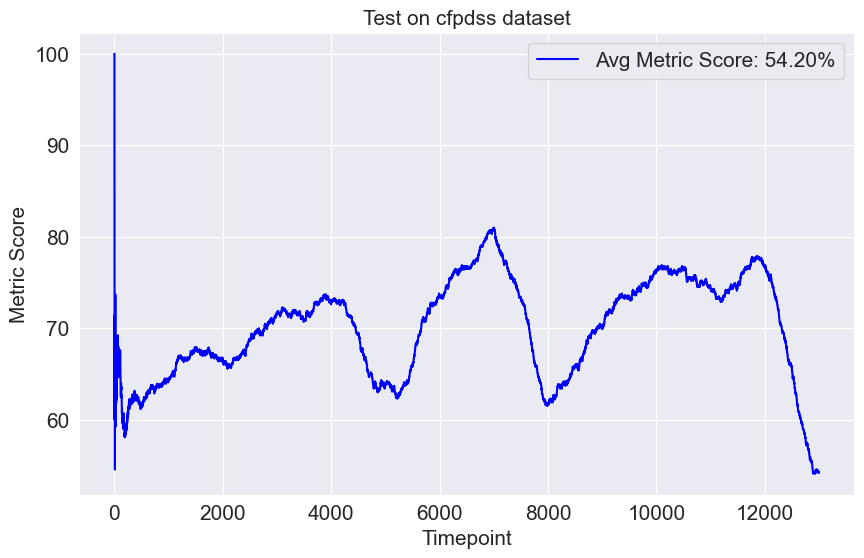

In [9]:
# ------ Function to plot to METRIC score of a model over the stream --------
def plot_metric_score_over_the_stream(
    model, X_df, y_df, metric_func, name, window_size=100
):
    metric_score_list = []  # record the real-time metric
    my_model = model
    window_y = deque(maxlen=window_size)

    # Stream data, updating the metric and checking for drifts
    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred = my_model.predict_one(xi)
        if y_pred is None:
            y_pred = 0
        my_model.learn_one(xi, yi)

        # Update the window with new prediction and get the current metric value of the window
        window_y.append((yi, y_pred))
        y_i_list, y_pred_list = zip(*window_y)
        y_i_list, y_pred_list = np.array(y_i_list), np.array(y_pred_list)
        windowed_metric_val = metric_func(y_i_list, y_pred_list) * 100
        metric_score_list.append(windowed_metric_val)

    # Plot the Metric Score Vs Timepoint graph
    plt.rcParams.update({"font.size": 15})
    plt.figure(1, figsize=(10, 6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(
        list(range(len(metric_score_list))),
        metric_score_list,
        "-b",
        label="Avg Metric Score: %.2f%%" % (metric_score_list[-1]),
    )

    plt.legend(loc="best")
    plt.title(name + " on cfpdss dataset", fontsize=15)
    plt.xlabel("Timepoint")
    plt.ylabel("Metric Score")

    # To zoom
    mplcursors.cursor(hover=True)
    plt.show()


plot_metric_score_over_the_stream(
    LogisticRegression(),
    X_df_encoded,
    y_encoded,
    accuracy_score,
    "Test",
    window_size=1000,
)

In [ ]:
# ------ Plot for all combination for model, metric WITHOUT drift adaptation -----
for model_name, model in models_dict.items():
    for metric_name, metric in metrics_dict.items():
        plot_metric_score_over_the_stream(
            model,
            X_df_encoded,
            y_encoded,
            metric,
            model_name + ", " + metric_name,
            window_size=200,
        )

In [17]:
# ------ Function to detect concept drift --------
def detect_concept_drift(
    model, X_df, y_df, metric_func, drift_detector, window_size=100
):
    timepoint = 0
    metric_score_list = []  # Record the real-time metric
    concept_drifts_timepoints = []
    my_model = model
    my_drift_detector = drift_detector

    window_y = deque(maxlen=window_size)

    # Stream data, updating the metric and checking for drifts
    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred = my_model.predict_one(xi)
        if y_pred is None:
            y_pred = 0
        my_model.learn_one(xi, yi)

        # Update the window with new prediction and get the current metric value of the window
        window_y.append((yi, y_pred))
        y_i_list, y_pred_list = zip(*window_y)
        y_i_list, y_pred_list = np.array(y_i_list), np.array(y_pred_list)
        windowed_metric_val = metric_func(y_i_list, y_pred_list) * 100

        # Recalculate the metric using only the values within the window
        if len(window_y) == window_size:

            my_drift_detector.update(windowed_metric_val)

            if my_drift_detector.drift_detected:
                concept_drifts_timepoints.append(timepoint)
                my_model = my_model.clone()  # Clone the model upon drift detection
                window_y.clear()  # Clear window on drift detection

        metric_score_list.append(windowed_metric_val)

        timepoint += 1
    print(f"no of concept drifts {len(concept_drifts_timepoints)}")
    print(f"Time points for concept drift {concept_drifts_timepoints}")
    return concept_drifts_timepoints, metric_score_list


l, z = detect_concept_drift(
    HoeffdingTreeClassifier(),
    X_df_encoded,
    y_encoded,
    accuracy_score,
    ADWIN(delta=0.0001),
    window_size=100,
)
z

no of concept drifts 66
Time points for concept drift [258, 421, 616, 843, 1038, 1233, 1460, 1687, 1946, 2173, 2336, 2531, 2694, 2857, 3020, 3247, 3442, 3669, 3832, 4059, 4350, 4513, 4740, 4903, 5098, 5325, 5488, 5715, 5878, 6041, 6204, 6431, 6626, 6821, 7048, 7211, 7374, 7537, 7764, 7927, 8090, 8253, 8416, 8643, 8870, 9033, 9228, 9391, 9618, 9845, 10008, 10235, 10430, 10593, 10820, 11015, 11274, 11501, 11664, 11827, 12022, 12249, 12444, 12607, 12802, 12965]


[100.0,
 100.0,
 66.66666666666666,
 75.0,
 60.0,
 50.0,
 57.14285714285714,
 50.0,
 55.55555555555556,
 50.0,
 54.54545454545454,
 58.333333333333336,
 61.53846153846154,
 64.28571428571429,
 66.66666666666666,
 68.75,
 64.70588235294117,
 66.66666666666666,
 68.42105263157895,
 70.0,
 71.42857142857143,
 68.18181818181817,
 65.21739130434783,
 66.66666666666666,
 68.0,
 69.23076923076923,
 70.37037037037037,
 71.42857142857143,
 72.41379310344827,
 73.33333333333333,
 74.19354838709677,
 75.0,
 75.75757575757575,
 76.47058823529412,
 77.14285714285715,
 77.77777777777779,
 78.37837837837837,
 78.94736842105263,
 79.48717948717949,
 80.0,
 80.48780487804879,
 78.57142857142857,
 79.06976744186046,
 77.27272727272727,
 77.77777777777779,
 78.26086956521739,
 76.59574468085107,
 75.0,
 75.51020408163265,
 76.0,
 76.47058823529412,
 76.92307692307693,
 75.47169811320755,
 75.92592592592592,
 76.36363636363637,
 76.78571428571429,
 77.19298245614034,
 77.58620689655173,
 77.96610169491525

In [ ]:
# ------ Function to plot concept drift -------------
def plot_concept_drift(
    concept_drifts_timepoints,
    metric_score_list,
    name: "Model Name + Drift Detector + Metric",
):
    plt.rcParams.update({"font.size": 15})
    plt.figure(1, figsize=(10, 6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(
        list(range(len(metric_score_list))),
        metric_score_list,
        "-b",
        label="Avg Metric Score: %.2f%%" % (metric_score_list[-1]),
    )

    plt.legend(loc="best")
    plt.title(name + " on cfpdss dataset", fontsize=15)
    plt.xlabel("Timepoint")
    plt.ylabel("Metric Score")

    # Plot concept drift with vertical lines
    for i in range(len(concept_drifts_timepoints)):
        # plt.text(self.concept_drifts_timepoints[i] - 500, 100.8, 'Drift ' + str(i), c="red", fontsize=25)
        plt.vlines(
            concept_drifts_timepoints[i],
            0,
            100,
            colors="red",
            linewidth=2,
            linestyles="dashed",
        )
    mplcursors.cursor(hover=True)

    plt.show()

In [ ]:
# ------ Plot for all combination for model, metric and drift detector (WITH drift adaptatio) -----
for model_name, model in models_dict.items():
    for metric_name, metric in metrics_dict.items():
        for drift_detector_name, drift_detector in drift_detectors_dict.items():
            print(model_name + ", " + metric_name + ", " + drift_detector_name)
            concept_drift_timepoints, metric_score_list = detect_concept_drift(
                model, X_df_encoded, y_encoded, metric, drift_detector, window_size=500
            )
            plot_concept_drift(
                concept_drift_timepoints,
                metric_score_list,
                model_name + ", " + metric_name + ", " + drift_detector_name,
            )

In [ ]:
# ----------- Linear Drift -------------------------
def _lin_incr(begin, end, i_begin, i_end, chunk):
    """
    Linear Drift : Linearly increments the values

    Parameters:

    begin = 0
    end = 10
    i_begin = 2
    i_end = 5
    chunk = 10
    Calculation:

    vals = 5 - 2 + 1 = 4
    srange = 10 - 0 = 10
    step = 10 / 4 = 2.5
    moving_values = np.arange(0, 10, 2.5) = [0.0, 2.5, 5.0, 7.5]
    Concatenation:

    [0]*2 = [0, 0] (first 2 elements are 0)
    moving_values = [0.0, 2.5, 5.0, 7.5] (linearly spaced values)
    [10]*(10 - 5 - 1) = [10, 10, 10, 10] (remaining elements are 10)
    Result:

    The final array is [0, 0, 0.0, 2.5, 5.0, 7.5, 10, 10, 10, 10]
    """
    # number of values to generate, inclusive of the beginning index OR end index
    vals = i_end - i_begin + 1  # 5 - 2 + 1 = 4 -------- this is from moving values
    # range of values to generate from
    srange = end - begin  # generate values from a range of 0 to 10 ....(10-0)
    # from the range of the values, and the number of values to generate,
    # derive the step size, inorder to generate the no of values given in given range
    step = srange / vals  # ------------- this is for moving valuez
    # moving_values = np.arange(begin, end * (1 + 1 / (vals + 1)), step)
    moving_values = np.arange(begin, end, step)
    return np.append(
        np.append(
            [begin] * i_begin, moving_values
        ),  # combine begin value, "i_begin" number of times,
        # before even starting with, the values begin, then after that append the moving values
        [end]
        * (
            chunk - i_end - 1
        ),  # now add the end values till with remaining size indicated by chunk
    )
    # result : [0, 0, 0.0, 2.5, 5.0, 7.5, 10, 10, 10, 10]
    # gives a linear increment in values


_lin_incr(begin=0, end=10, i_begin=2, i_end=5, chunk=10)

In [ ]:
import numpy as np
from river import metrics, linear_model, preprocessing
from river.drift import ADWIN  # Using ADWIN as an example drift detector


# Example metric function: Mean Squared Error
def mse_metric(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()


# Simulated data with a linear drift
X_df = pd.DataFrame({"feature": _lin_incr(0, 10, 2, 5, 100)})
y_df = pd.Series(_lin_incr(0, 10, 2, 5, 100))

# Initialize model and drift detector
model = preprocessing.StandardScaler() | linear_model.LinearRegression()
drift_detector = ADWIN()

# Detect concept drift
concept_drifts_timepoints, metric_score_list = detect_concept_drift(
    model, X_df, y_df, mse_metric, drift_detector, window_size=10
)

print(f"Detected concept drifts at timepoints: {concept_drifts_timepoints}")
print(f"Metric score list over time: {metric_score_list}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def detect_linear_drift(data, window_size=10, threshold=2):
    """
    Detects linear drift in a feature using a moving average and CUSUM approach.

    Parameters:
    - data: A pandas Series or numpy array containing the feature data.
    - window_size: The size of the window for the moving average.
    - threshold: The threshold for detecting drift in the CUSUM algorithm.

    Returns:
    - drift_points: Indices where drift is detected.
    - cusum_pos: Positive CUSUM values for plotting.
    - cusum_neg: Negative CUSUM values for plotting.
    """
    # Compute the moving average
    moving_avg = data.rolling(window=window_size, min_periods=1).mean()

    # Compute the differences between the actual data and the moving average
    diffs = data - moving_avg

    # CUSUM positive and negative statistics
    cusum_pos = np.zeros(len(data))
    cusum_neg = np.zeros(len(data))

    for i in range(1, len(data)):
        cusum_pos[i] = max(0, cusum_pos[i - 1] + diffs[i] - threshold)
        cusum_neg[i] = min(0, cusum_neg[i - 1] + diffs[i] + threshold)

    # Detect points where the CUSUM statistic exceeds the threshold
    drift_points = np.where((cusum_pos > threshold) | (cusum_neg < -threshold))[0]

    return drift_points, cusum_pos, cusum_neg


# Simulate data with a linear drift
data = pd.Series(_lin_incr(0, 10, 15, 25, 100))
print(list(data))
# Detect linear drift
drift_points, cusum_pos, cusum_neg = detect_linear_drift(
    data, window_size=20, threshold=2
)

# Plot the data and detected drift points
plt.figure(figsize=(12, 6))
plt.plot(data, label="Feature Data")
plt.plot(
    data.rolling(window=5, min_periods=1).mean(), label="Moving Average", linestyle="--"
)
plt.scatter(
    drift_points, data.iloc[drift_points], color="red", label="Detected Drift Points"
)
plt.title("Linear Drift Detection in Feature Data")
plt.xlabel("Time")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

print(f"Detected drift points at indices: {drift_points}")

In [ ]:
def exp_weighted_metric(y_true, y_pred, alpha):
    weights = np.exp(-alpha * np.arange(len(y_true))[::-1])
    return np.sum(weights * (y_true == y_pred)) / np.sum(weights)


def detect_concept_drift_exp_weighted(
    model, X_df, y_df, metric_func, drift_detector, alpha=0.01
):
    timepoint = 0
    metric_score_list = []  # Record the real-time metric
    concept_drifts_timepoints = []
    my_model = model
    my_drift_detector = drift_detector

    window_y = deque()

    # Stream data, updating the metric and checking for drifts
    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred = my_model.predict_one(xi)
        if y_pred is None:
            y_pred = 0
        my_model.learn_one(xi, yi)

        # Update the window with new prediction and get the current metric value of the window
        window_y.append((yi, y_pred))
        if len(window_y) > 1:
            y_i_list, y_pred_list = zip(*window_y)
            y_i_list, y_pred_list = np.array(y_i_list), np.array(y_pred_list)
            windowed_metric_val = (
                exp_weighted_metric(y_i_list, y_pred_list, alpha) * 100
            )

            my_drift_detector.update(windowed_metric_val)

            if my_drift_detector.drift_detected:
                concept_drifts_timepoints.append(timepoint)
                my_model = my_model.clone()  # Clone the model upon drift detection
                window_y.clear()  # Clear window on drift detection

            metric_score_list.append(windowed_metric_val)

        timepoint += 1
    print(f"Number of concept drifts: {len(concept_drifts_timepoints)}")
    print(f"Time points for concept drift: {concept_drifts_timepoints}")
    return concept_drifts_timepoints, metric_score_list


z = detect_concept_drift_exp_weighted(
    LogisticRegression(), X_df_encoded, y_encoded, accuracy_score, ADWIN()
)

In [ ]:
def detect_concept_drift_expanding(model, X_df, y_df, metric_func, drift_detector):
    timepoint = 0
    metric_score_list = []  # Record the real-time metric
    concept_drifts_timepoints = []
    my_model = model
    my_drift_detector = drift_detector

    y_true, y_pred = [], []

    # Stream data, updating the metric and checking for drifts
    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred_i = my_model.predict_one(xi)
        if y_pred_i is None:
            y_pred_i = 0
        my_model.learn_one(xi, yi)

        # Update the lists with new prediction and get the current metric value
        y_true.append(yi)
        y_pred.append(y_pred_i)

        if len(y_true) > 1:
            windowed_metric_val = metric_func(np.array(y_true), np.array(y_pred)) * 100
            my_drift_detector.update(windowed_metric_val)

            if my_drift_detector.drift_detected:
                concept_drifts_timepoints.append(timepoint)
                my_model = my_model.clone()  # Clone the model upon drift detection
                y_true, y_pred = [], []  # Clear the lists on drift detection

            metric_score_list.append(windowed_metric_val)

        timepoint += 1
    print(f"Number of concept drifts: {len(concept_drifts_timepoints)}")
    print(f"Time points for concept drift: {concept_drifts_timepoints}")
    return concept_drifts_timepoints, metric_score_list


z = detect_concept_drift_expanding(
    LogisticRegression(), X_df_encoded, y_encoded, accuracy_score, ADWIN()
)

In [ ]:
from collections import deque
import numpy as np
from river import stream
from river.tree import HoeffdingTreeClassifier
from river.drift import ADWIN
from sklearn.metrics import accuracy_score


def detect_concept_drift_expanding_sliding(
    model, X_df, y_df, metric_func, drift_detector, window_size=100
):
    timepoint = 0
    metric_score_list = []  # Record the real-time metric
    concept_drifts_timepoints = []
    my_model = model
    my_drift_detector = drift_detector

    expanding_y = []  # Expanding window
    sliding_y = deque(maxlen=window_size)  # Sliding window

    # Stream data, updating the metric and checking for drifts
    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred = my_model.predict_one(xi)
        if y_pred is None:
            y_pred = 0
        my_model.learn_one(xi, yi)

        # Update the windows with new prediction
        expanding_y.append((yi, y_pred))
        sliding_y.append((yi, y_pred))

        # Calculate the expanding window metric
        y_expanding, y_pred_expanding = zip(*expanding_y)
        y_expanding, y_pred_expanding = np.array(y_expanding), np.array(
            y_pred_expanding
        )
        expanding_metric_val = metric_func(y_expanding, y_pred_expanding) * 100

        # Calculate the sliding window metric if it's full
        if len(sliding_y) == window_size:
            y_sliding, y_pred_sliding = zip(*sliding_y)
            y_sliding, y_pred_sliding = np.array(y_sliding), np.array(y_pred_sliding)
            sliding_metric_val = metric_func(y_sliding, y_pred_sliding) * 100

            # Check drift on sliding window
            my_drift_detector.update(sliding_metric_val)
            if my_drift_detector.drift_detected:
                concept_drifts_timepoints.append(timepoint)
                my_model = my_model.clone()  # Clone the model upon drift detection
                expanding_y.clear()  # Clear expanding window
                sliding_y.clear()  # Clear sliding window
                my_drift_detector = (
                    drift_detector.__class__()
                )  # Reset the drift detector

        metric_score_list.append(
            expanding_metric_val
        )  # Use expanding metric for overall metric tracking

        timepoint += 1
    print(f"Number of concept drifts: {len(concept_drifts_timepoints)}")
    print(f"Time points for concept drift: {concept_drifts_timepoints}")
    return concept_drifts_timepoints, metric_score_list


# Example usage
# Assuming X_df_encoded and y_encoded are already defined
z = detect_concept_drift_expanding_sliding(
    LogisticRegression(),
    X_df_encoded,
    y_encoded,
    cohen_kappa_score,
    ADWIN(),
    window_size=100,
)

In [ ]:
from collections import deque
import numpy as np
from river import stream
from river.tree import HoeffdingTreeClassifier
from river.drift import ADWIN
from sklearn.metrics import accuracy_score


def exp_weighted_metric(y_true, y_pred, alpha):
    weights = np.exp(-alpha * np.arange(len(y_true))[::-1])
    return np.sum(weights * (y_true == y_pred)) / np.sum(weights)


def detect_concept_drift_exp_sliding(
    model, X_df, y_df, metric_func, drift_detector, window_size=100, alpha=0.01
):
    timepoint = 0
    metric_score_list = []  # Record the real-time metric
    concept_drifts_timepoints = []
    my_model = model
    my_drift_detector = drift_detector

    window_y = deque(maxlen=window_size)

    # Stream data, updating the metric and checking for drifts
    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred = my_model.predict_one(xi)
        if y_pred is None:
            y_pred = 0
        my_model.learn_one(xi, yi)

        # Update the window with new prediction and get the current metric value of the window
        window_y.append((yi, y_pred))
        if len(window_y) == window_size:
            y_i_list, y_pred_list = zip(*window_y)
            y_i_list, y_pred_list = np.array(y_i_list), np.array(y_pred_list)
            windowed_metric_val = (
                exp_weighted_metric(y_i_list, y_pred_list, alpha) * 100
            )

            my_drift_detector.update(windowed_metric_val)

            if my_drift_detector.drift_detected:
                concept_drifts_timepoints.append(timepoint)
                # my_model = my_model.clone()  # Clone the model upon drift detection
                window_y.clear()  # Clear window on drift detection

            metric_score_list.append(windowed_metric_val)

        timepoint += 1
    print(f"Number of concept drifts: {len(concept_drifts_timepoints)}")
    print(f"Time points for concept drift: {concept_drifts_timepoints}")
    return concept_drifts_timepoints, metric_score_list


# Example usage
z = detect_concept_drift_exp_sliding(
    LogisticRegression(),
    X_df_encoded,
    y_encoded,
    accuracy_score,
    ADWIN(),
    window_size=100,
    alpha=0.01,
)